In [38]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import os
import time
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import seaborn as sns
sns.set(color_codes=True)
from pathlib import Path
import matplotlib.pyplot as plt
import hvplot.pandas

import pandas_ta as ta
from fastai.tabular.all import add_datepart

import datetime
from dateutil.relativedelta import relativedelta

import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV,KFold
from sklearn.metrics import mean_absolute_error
import pickle

import trade



## Initializations

In [39]:
ticker = 'NVDA'

outfile = ('./Resources/' + str(ticker) +'_out.csv') # output data for review

stock_data_period = '4y'
stock_data_interval = '1d'

sma_short = 4
sma_long = 50
sma_period = 20
bbands_period = 20
macd_fast = 8
macd_slow = 21



___
## Get and Prepare Data

In [40]:
# Get live stock data
df = pd.DataFrame()
df = df.ta.ticker(ticker, period = stock_data_period, interval = stock_data_interval)
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-10-01,70.467013,72.426082,70.080159,71.756523,62206000,0.0,0.0
2018-10-02,71.481256,72.599664,70.819137,71.042328,38396400,0.0,0.0
2018-10-03,71.746616,71.821008,70.062805,71.104340,32055200,0.0,0.0
2018-10-04,70.742275,70.985302,68.488105,69.259338,39122000,0.0,0.0
2018-10-05,69.011329,69.633762,66.345506,66.920822,42663600,0.0,0.0
...,...,...,...,...,...,...,...
2022-09-26,124.910004,126.589996,122.139999,122.279999,54734300,0.0,0.0
2022-09-27,125.070000,127.360001,122.580002,124.129997,55385400,0.0,0.0
2022-09-28,124.099998,128.229996,123.540001,127.360001,54241400,0.0,0.0


In [41]:
df['Actual Returns'] = df['Close'].pct_change()
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Actual Returns
Date,,,,,,,,
2018-10-01,70.467013,72.426082,70.080159,71.756523,62206000,0.0,0.0,NaN
2018-10-02,71.481256,72.599664,70.819137,71.042328,38396400,0.0,0.0,-0.009953
2018-10-03,71.746616,71.821008,70.062805,71.104340,32055200,0.0,0.0,0.000873
2018-10-04,70.742275,70.985302,68.488105,69.259338,39122000,0.0,0.0,-0.025948
2018-10-05,69.011329,69.633762,66.345506,66.920822,42663600,0.0,0.0,-0.033765


In [42]:
# Visualize close price
close = df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)
close

:Curve   [Date]   (Close)

## Add features/columns to dataframe using technical indicators from Pandas_TA

In [43]:
CustomStrategy = ta.Strategy(
    name="Momo and Volatility",
    description="SMA 4,50, BBANDS, RSI, MACD and Volume SMA 20",
    ta=[
        {"kind": "sma", "length": sma_long},
        {"kind": "sma", "length": sma_short},
        {"kind": "bbands", "length": bbands_period},
        {"kind": "rsi"},
        {"kind": "macd", "fast": macd_fast, "slow": macd_slow},
        {"kind": "sma", "close": "volume", "length": sma_period, "prefix": "VOLUME"},
    ]
)
# Run "Custom Strategy" to add additional features/columns to dataframe.
df.ta.strategy(CustomStrategy)

In [44]:
df['Actual Returns'] = df['Close'].pct_change()
df[['Close','SMA_50','SMA_4','BBL_20_2.0','BBM_20_2.0','BBU_20_2.0','BBB_20_2.0','BBP_20_2.0','RSI_14','MACD_8_21_9','MACDh_8_21_9','MACDs_8_21_9','VOLUME_SMA_20']]=df[['Close','SMA_50','SMA_4','BBL_20_2.0','BBM_20_2.0','BBU_20_2.0','BBB_20_2.0','BBP_20_2.0','RSI_14','MACD_8_21_9','MACDh_8_21_9','MACDs_8_21_9','VOLUME_SMA_20']].shift(-1)

## Generate Trading Signal

In [45]:
# Generate buy/sell signal
df['Signal'] = 0.0
# Generate signal to buy stock
df.loc[(df['Actual Returns'] >= 0), 'Signal'] = 1
# Generate signal to sell stock
df.loc[(df['Actual Returns'] < 0), 'Signal'] = 0

In [46]:
df.reset_index(inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Actual Returns,SMA_50,...,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,RSI_14,MACD_8_21_9,MACDh_8_21_9,MACDs_8_21_9,VOLUME_SMA_20,Signal
0,2018-10-01,70.467013,72.426082,70.080159,71.042328,62206000,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2018-10-02,71.481256,72.599664,70.819137,71.104340,38396400,0.0,0.0,-0.009953,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,2018-10-03,71.746616,71.821008,70.062805,69.259338,32055200,0.0,0.0,0.000873,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,2018-10-04,70.742275,70.985302,68.488105,66.920822,39122000,0.0,0.0,-0.025948,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,2018-10-05,69.011329,69.633762,66.345506,65.906578,42663600,0.0,0.0,-0.033765,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


## Add date related features/coumns to dataframe

In [47]:
add_datepart(df, 'Date', drop=False)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Actual Returns,SMA_50,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,2018-10-01,70.467013,72.426082,70.080159,71.042328,62206000,0.0,0.0,NaN,NaN,...,1,0,274,False,True,False,True,False,False,1.538352e+09
1,2018-10-02,71.481256,72.599664,70.819137,71.104340,38396400,0.0,0.0,-0.009953,NaN,...,2,1,275,False,False,False,False,False,False,1.538438e+09
2,2018-10-03,71.746616,71.821008,70.062805,69.259338,32055200,0.0,0.0,0.000873,NaN,...,3,2,276,False,False,False,False,False,False,1.538525e+09
3,2018-10-04,70.742275,70.985302,68.488105,66.920822,39122000,0.0,0.0,-0.025948,NaN,...,4,3,277,False,False,False,False,False,False,1.538611e+09
4,2018-10-05,69.011329,69.633762,66.345506,65.906578,42663600,0.0,0.0,-0.033765,NaN,...,5,4,278,False,False,False,False,False,False,1.538698e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,2022-09-26,124.910004,126.589996,122.139999,124.129997,54734300,0.0,0.0,-0.023011,161.116321,...,26,0,269,False,False,False,False,False,False,1.664150e+09
1004,2022-09-27,125.070000,127.360001,122.580002,127.360001,55385400,0.0,0.0,0.015129,160.266131,...,27,1,270,False,False,False,False,False,False,1.664237e+09
1005,2022-09-28,124.099998,128.229996,123.540001,122.199997,54241400,0.0,0.0,0.026021,159.149789,...,28,2,271,False,False,False,False,False,False,1.664323e+09
1006,2022-09-29,124.480003,125.000000,119.459999,121.389999,53276300,0.0,0.0,-0.040515,157.968661,...,29,3,272,False,False,False,False,False,False,1.664410e+09


In [48]:
# Drop irrelevant columns
df.drop(columns=['Dividends', 'Stock Splits', 'Open', 'High', 'Low', 'Year'],inplace=True,axis=1)

In [49]:
df=df.iloc[51:]
df=df.iloc[:-1]
df.head()

,Date,Close,Volume,Actual Returns,SMA_50,SMA_4,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
51,2018-12-13,36.353519,47138400,-0.000067,48.815062,36.764972,32.302108,38.648101,44.994094,32.839869,...,13,3,347,False,False,False,False,False,False,1.544659e+09
52,2018-12-14,35.641109,47182000,-0.016388,48.142697,36.478887,34.270588,37.920687,41.570786,19.251228,...,14,4,348,False,False,False,False,False,False,1.544746e+09
53,2018-12-17,36.475170,66286800,-0.019597,47.533784,36.357254,34.252292,37.705649,41.159005,18.317449,...,17,0,351,False,False,False,False,False,False,1.545005e+09
54,2018-12-18,34.382572,56437200,0.023402,46.903304,35.713093,33.963537,37.630616,41.297696,19.489873,...,18,1,352,False,False,False,False,False,False,1.545091e+09
55,2018-12-19,33.536106,74536400,-0.057370,46.257035,35.008739,33.385237,37.458952,41.532667,21.750290,...,19,2,353,False,False,False,False,False,False,1.545178e+09


In [50]:
df=df.set_index(['Date'])

___
## Calculate P&L and ROI based on trading signal

In [51]:
# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
pl_df = df[['Close', 'Signal']].copy()
pl_df['Entry/Exit'] = pl_df['Signal'].diff()
pl_df.head()


,Close,Signal,Entry/Exit
Date,,,
2018-12-13,36.353519,0.0,NaN
2018-12-14,35.641109,0.0,0.0
2018-12-17,36.475170,0.0,0.0
2018-12-18,34.382572,1.0,1.0
2018-12-19,33.536106,0.0,-1.0


In [52]:
pl_df['Entry/Exit'].value_counts()

 0.0    459
 1.0    248
-1.0    248
Name: Entry/Exit, dtype: int64

#### Execute trades based on the entry/exit signals and calculate P&L

In [53]:
pl_df, initial_investment, accumulated_shares = trade.gain_loss(pl_df)

In [54]:
# Accumulated shares should show zero since all remaining shares have been sold at 'last' day of dataset
print("Accumulated shares =", accumulated_shares)
print (f"The initial investment made is ${initial_investment:,.2f}" )

# Calculate the total profit/loss for 100 share size orders
total_profit_loss = pl_df["cost/proceeds"].sum()

# Print the profit/loss metrics
print(f"The total profit/loss of the trading strategy is ${total_profit_loss:,.2f}")

# Calculate the return on investment (ROI)
roi = (total_profit_loss / initial_investment) * 100

# Print the ROI
print(f"The trading algorithm resulted in a return on investment of {roi:,.2f}%")

Accumulated shares = 0
The initial investment made is $3,438.26
The total profit/loss of the trading strategy is $3,141.46
The trading algorithm resulted in a return on investment of 91.37%


---
## Algorithmic Trading - Plot Cummulative Returns

In [55]:
# Filter the date index and close columns
df_bt = df.loc[:, ['Close', 'Actual Returns', 'Signal']]

# # Use the pct_change function to generate  returns from close prices
# df_bt["Actual Returns"] = df_bt["Close"].pct_change()

# # Drop all NaN values from the DataFrame
# df_bt = df_bt.dropna()

df_bt['Strategy Returns'] = (df_bt['Actual Returns'] * df_bt['Signal'])

df_bt.head()

,Close,Actual Returns,Signal,Strategy Returns
Date,,,,
2018-12-13,36.353519,-0.000067,0.0,-0.000000
2018-12-14,35.641109,-0.016388,0.0,-0.000000
2018-12-17,36.475170,-0.019597,0.0,-0.000000
2018-12-18,34.382572,0.023402,1.0,0.023402
2018-12-19,33.536106,-0.057370,0.0,-0.000000


<AxesSubplot:xlabel='Date'>

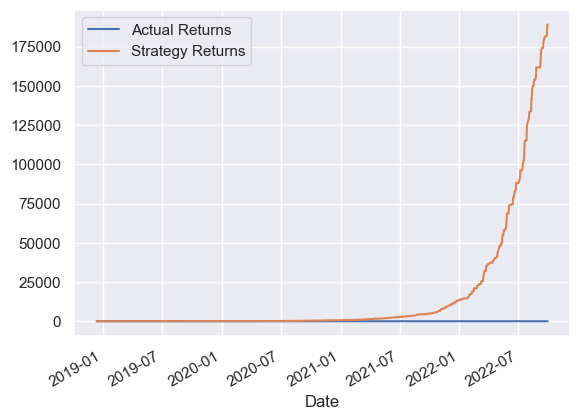

In [56]:
(1 + df_bt[['Actual Returns', 'Strategy Returns']]).cumprod().plot()

---
## Machine Learning

#### Extract features and target

In [57]:
# Extract features 
X = df.drop(columns=['Actual Returns', 'Signal'])
X.head()

,Close,Volume,SMA_50,SMA_4,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,RSI_14,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-13,36.353519,47138400,48.815062,36.764972,32.302108,38.648101,44.994094,32.839869,0.319210,34.813186,...,13,3,347,False,False,False,False,False,False,1.544659e+09
2018-12-14,35.641109,47182000,48.142697,36.478887,34.270588,37.920687,41.570786,19.251228,0.187738,33.519211,...,14,4,348,False,False,False,False,False,False,1.544746e+09
2018-12-17,36.475170,66286800,47.533784,36.357254,34.252292,37.705649,41.159005,18.317449,0.321843,36.495263,...,17,0,351,False,False,False,False,False,False,1.545005e+09
2018-12-18,34.382572,56437200,46.903304,35.713093,33.963537,37.630616,41.297696,19.489873,0.057135,32.557349,...,18,1,352,False,False,False,False,False,False,1.545091e+09
2018-12-19,33.536106,74536400,46.257035,35.008739,33.385237,37.458952,41.532667,21.750290,0.018517,31.095715,...,19,2,353,False,False,False,False,False,False,1.545178e+09


In [58]:
# Extract target
y = df['Signal']

y.value_counts()

1.0    516
0.0    440
Name: Signal, dtype: int64

#### Split train - test data

In [59]:
training_begin = X.index.min() + DateOffset(months=14)
training_end = X.index.max() - DateOffset(months=5)
print(training_begin)
print(training_end) 

2020-02-13 00:00:00
2022-04-29 00:00:00


In [60]:
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

In [61]:
# Scale the features data

scaler = StandardScaler()

X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(558, 26) (558,)
(106, 26) (106,)


In [62]:
# Use RandomOverSampler to resample the dataset using random_state=1
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)
print(len(X_resampled))
print(len(y_resampled))

604
604


#### Train machine learning model

In [63]:
# Instantiate model using XGBClassifier
model = xgb.XGBClassifier()

# Fit/train the model
model = model.fit(X_resampled, y_resampled)

# Use the trained model to predict trading signals
training_signal_predictions = model.predict(X_resampled)

In [64]:
# Print classification report on training dataset
training_report = classification_report(y_resampled, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       302
         1.0       1.00      1.00      1.00       302

    accuracy                           1.00       604
   macro avg       1.00      1.00      1.00       604
weighted avg       1.00      1.00      1.00       604



In [65]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = model.predict(X_test_scaled)

# Evaluate the model's ability to predict the trading signal for the testing data using a classification report
testing_report = classification_report(y_test, testing_signal_predictions)

print(testing_report)


              precision    recall  f1-score   support

         0.0       0.58      0.70      0.64        54
         1.0       0.61      0.48      0.54        52

    accuracy                           0.59       106
   macro avg       0.60      0.59      0.59       106
weighted avg       0.60      0.59      0.59       106



In [66]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df['Predicted Signal'] = testing_signal_predictions

# Add in actual returns and calculate trading returns
predictions_df['Actual Returns'] = df['Actual Returns']
predictions_df['ML Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted Signal']
predictions_df.tail(20)


,Predicted Signal,Actual Returns,ML Returns
Date,,,
2022-09-01,0,-0.076653,-0.000000
2022-09-02,1,-0.020808,-0.020808
2022-09-06,0,-0.013336,-0.000000
2022-09-07,0,0.018795,0.000000
2022-09-08,0,0.020125,0.000000
2022-09-09,0,0.028377,0.000000
2022-09-12,0,0.008202,0.000000
2022-09-13,0,-0.094726,-0.000000
2022-09-14,0,-0.000228,-0.000000


<AxesSubplot:xlabel='Date'>

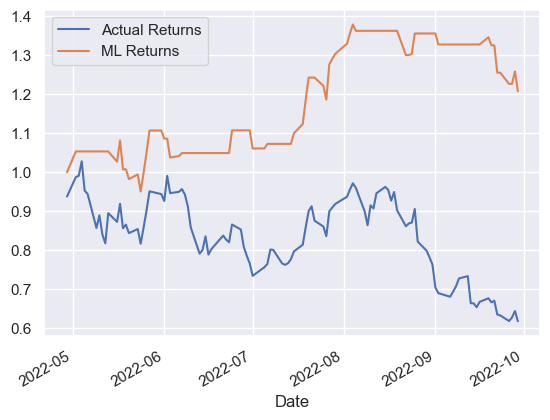

In [67]:
# Calculate and plot the cumulative returns for the `Actual Returns` and the `Algo Returns`
(1 + predictions_df[['Actual Returns', 'ML Returns']]).cumprod().plot()

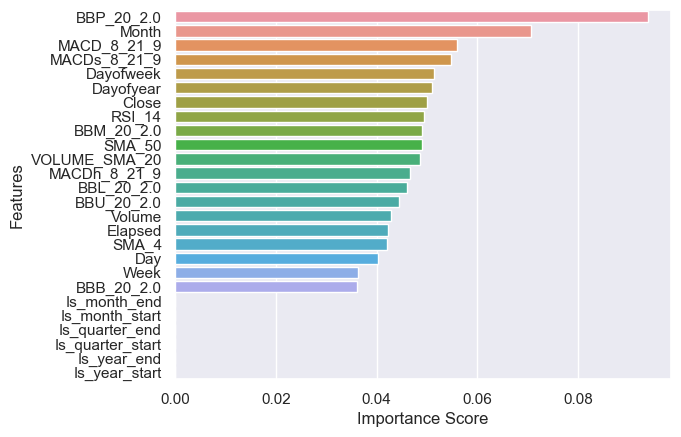

In [68]:
# Show ranking of importance score of features for this dataset
imp_score = pd.DataFrame(model.feature_importances_, columns=['Importance Score'])
features = pd.DataFrame(X.columns, columns=['Features'])
feature_imp = pd.concat([features,imp_score], axis=1)
feature_imp = feature_imp.sort_values(by='Importance Score', ascending=False)
sns.barplot(x=feature_imp['Importance Score'], y=feature_imp['Features'])
plt.show()

In [69]:
pickle.dump(model, open(('./Resources/' + ticker + '_ml_model.pkl'), 'wb'))

___
## Calculate P&L and ROI based on ML predicted trading signal

In [70]:
# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
predictions_df['Close'] = df['Close']
predictions_df


,Predicted Signal,Actual Returns,ML Returns,Close
Date,,,,
2022-04-29,0,-0.062431,-0.000000,195.230698
2022-05-02,1,0.053162,0.053162,195.920364
2022-05-03,0,0.003533,0.000000,203.236618
2022-05-04,0,0.037343,0.000000,188.344208
2022-05-05,0,-0.073276,-0.000000,186.655060
...,...,...,...,...
2022-09-23,0,-0.003582,-0.000000,122.279999
2022-09-26,1,-0.023011,-0.023011,124.129997
2022-09-27,0,0.015129,0.000000,127.360001


In [71]:
pl_df = predictions_df[['Close', 'Predicted Signal']].copy()
pl_df['Entry/Exit'] = pl_df['Predicted Signal'].diff()
pl_df.head()

,Close,Predicted Signal,Entry/Exit
Date,,,
2022-04-29,195.230698,0,NaN
2022-05-02,195.920364,1,1.0
2022-05-03,203.236618,0,-1.0
2022-05-04,188.344208,0,0.0
2022-05-05,186.655060,0,0.0


In [72]:
pl_df['Entry/Exit'].value_counts()

 0.0    72
 1.0    17
-1.0    16
Name: Entry/Exit, dtype: int64

In [73]:
pl_df, initial_investment, accumulated_shares = trade.gain_loss(pl_df)

In [74]:
# Accumulated shares should show zero since all remaining shares have been sold at 'last' day of dataset
print("Accumulated shares =", accumulated_shares)
print (f"The initial investment made is ${initial_investment:,.2f}" )

# Calculate the total profit/loss for 100 share size orders
total_profit_loss = pl_df["cost/proceeds"].sum()

# Print the profit/loss metrics
print(f"The total profit/loss of the trading strategy is ${total_profit_loss:,.2f}")

# Calculate the return on investment (ROI)
roi = (total_profit_loss / initial_investment) * 100

# Print the ROI
print(f"The trading algorithm resulted in a return on investment of {roi:,.2f}%")

Accumulated shares = 0
The initial investment made is $19,592.04
The total profit/loss of the trading strategy is $-2,383.40
The trading algorithm resulted in a return on investment of -12.17%
